# Predictions notebook

In [1]:
import pandas as pd
import numpy as np
from joblib import load
from pytorch_tabnet.tab_model import TabNetClassifier
from helpers import plot_roc_curve, preprocess_catboost, preprocess_tabnet_data

In [2]:
train_data = pd.read_excel('data/existing-customers.xlsx')
pred_data = pd.read_excel('data/potential-customers.xlsx')

/Users/jniedziela/.pyenv/versions/3.10.0/envs/DM/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/jniedziela/.pyenv/versions/3.10.0/envs/DM/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
catboost = load('catboost_models/calibrated_v2.joblib')
tabnet = TabNetClassifier()
tabnet.load_model('tabnet/tabnet_model_final.pt.zip')

/Users/jniedziela/.pyenv/versions/3.10.0/envs/DM/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [6]:
tabnet_train = (preprocess_tabnet_data(train_data, for_prediction=True))
tabnet_pred_data = (preprocess_tabnet_data(pred_data, for_prediction=True))

catboost_train = (preprocess_catboost(train_data))
catboost_pred_data = (preprocess_catboost(pred_data, for_prediction=True))

cat_X = pd.concat([catboost_train[0], catboost_train[1]]).sort_index()
cat_y = pd.concat([catboost_train[2], catboost_train[3]]).sort_index()

tab_X = tabnet_train[0].drop('class', axis=1)
tab_y = tabnet_train[0]['class']

/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_9581/175105498.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col].iloc[i] = rep_value
/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_9581/175105498.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col].iloc[i] = rep_value
/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_9581/175105498.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

# Sanity check if models are same as in other files

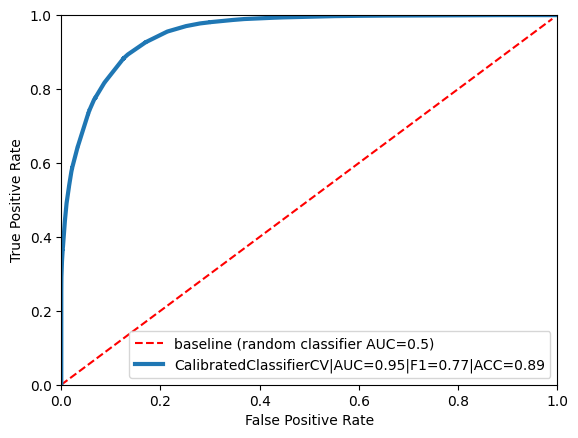

In [7]:
plot_roc_curve(catboost, cat_X, cat_y, '>50K')

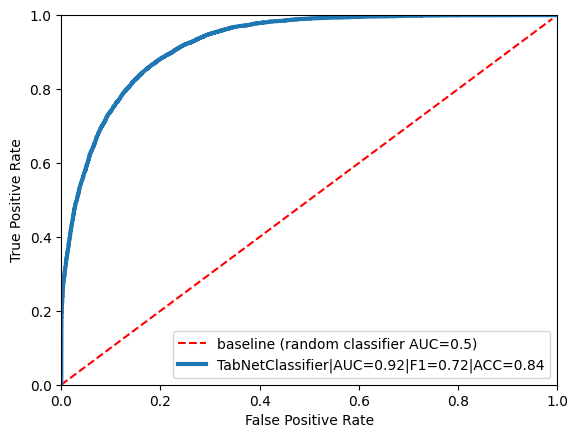

In [8]:
plot_roc_curve(tabnet, tab_X.values, tab_y.values, 1)

# Check ensemble results (Tabnet + Catboost)

In [9]:
from sklearn.metrics import roc_curve, f1_score, roc_auc_score, accuracy_score
from matplotlib import pyplot as plt

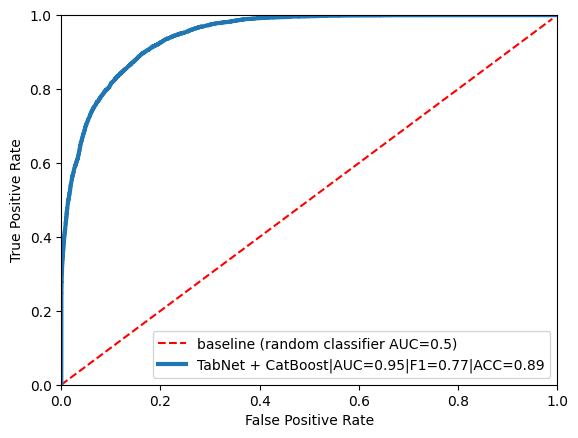

In [10]:
# check the ensemble prediction
tab_pred = tabnet.predict_proba(tab_X.values)
cat_pred = catboost.predict_proba(cat_X)
clasifier_name = 'TabNet + CatBoost'

ensemble_pred = (tab_pred + cat_pred) / 2
y_pred = (ensemble_pred[:, 1] > 0.5).astype(int)
y_prob = ensemble_pred[:, 1]

pos_label = 1
y = tab_y


# calculate the scores
fpr, tpr, thresholds = roc_curve(y, y_prob, pos_label=pos_label)
auc = roc_auc_score(y, y_prob)
f1 = f1_score(y, y_pred, pos_label=pos_label)
acc = accuracy_score(y, y_pred)
baseline = np.arange(0, 1, 0.01)

# plot the roc curve
plt.plot(baseline, baseline, color='red', linestyle='dashed', label='baseline (random classifier AUC=0.5)')
plt.plot(fpr, tpr, linewidth=3, label=f'{clasifier_name}|AUC={auc:.2f}|F1={f1:.2f}|ACC={acc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.legend(loc="lower right")

# Final predictions

In [18]:
tab_pred = tabnet.predict_proba(tabnet_pred_data[0].values)
cat_pred = catboost.predict_proba(catboost_pred_data[0])

ensemble_probs = (tab_pred + cat_pred) / 2

## Threshold to maximize expected return

As to maximize the expected returns, there is no need to send the promotions to customers which are unlikely to be in higher income bracket. Because of this below there is a code to chose the threshold that maximizes expected returns.

In [44]:
best = {
    'threshold': 0.01,
    'total': 0
}
for t in np.arange(0.01, 1, 0.01):
    total = 0
    n = 0
    for prob in ensemble_probs:
        if prob[1] > t:  # income more than 50K
            n += 1
            total += (980 * prob[1] - 310 * prob[0])
    total -= n * 10
    if total > best['total']:
        best['total'] = total
        best['threshold'] = t

best

{'threshold': 0.25, 'total': 2975581.544008378}

In [45]:
final_predictions = (ensemble_probs[:, 1] > best['threshold']).astype(int)
assert len(final_predictions) == len(pred_data)  # check if the length of the predictions is the same as the length of the test data
assert all(catboost_pred_data[1] == tabnet_pred_data[1])  # check if the order is the same
cust_ids = catboost_pred_data[1]
customers_to_send = cust_ids[final_predictions == 1]

In [46]:
customers_to_send.to_csv('results/potential_customers.csv', index=False)